<a href="https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/simulated_annealing_2d_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulated annealing on a 2d surface

Code is based on

https://krischer.github.io/seismo_live_build/html/Seismic%20Inverse%20Problems/Probabilistic%20Inversion/pi_simann_wrapper.html

and modified by murphyk@ and Neoanarika@


In [1]:
import numpy as np
import matplotlib

matplotlib.use("nbagg")
import matplotlib.pyplot as plt
from IPython import display


from mpl_toolkits.mplot3d import Axes3D

In [2]:

!mkdir figures
!mkdir scripts
%cd /content/scripts
!wget -q https://raw.githubusercontent.com/probml/pyprobml/master/scripts/pyprobml_utils.py
import pyprobml_utils as pml


/content/scripts


# Target distribution

We use  the [peaks](https://www.mathworks.com/help/matlab/ref/peaks.html) function from matlab, modified so it is positive:
$$
p(x,y) \propto  |3 (1-x)^2 e^{-x^2 - (y+1)^2}  
   - 10 (\frac{x}{5} - x^3 - y^5) e^{-x^2 -y^2} 
   - \frac{1}{3} e^{-(x+1)^2 - y^2} |
$$


In [3]:
# Generate a pdf

# the following steps generate a pdf; this is equivalent to the function "peaks(n)" in matlab
n = 100  # number of dimension
pdf = np.zeros([n, n])
sigma = np.zeros([n, n])
s = np.zeros([n, n])
x = -3.0
for i in range(0, n):
    y = -3.0
    for j in range(0, n):
        pdf[j, i] = (
            3.0 * (1 - x) ** 2 * np.exp(-(x**2) - (y + 1) ** 2)
            - 10.0 * (x / 5 - x**3 - y**5) * np.exp(-(x**2) - y**2)
            - 1.0 / 3 * np.exp(-((x + 1) ** 2) - y**2)
        )
        if pdf[j, i] < 0:
            pdf[j, i] = pdf[j, i] * (
                -1
            )  # in contrast to the peaks function: all negative values are multiplied by (-1)
        y = y + 6.0 / (n - 1)
    x = x + 6.0 / (n - 1)

pdf = pdf / pdf.max()
energy = -np.log(pdf)

saving image to ../figures/sim_anneal_2d_peaks.pdf


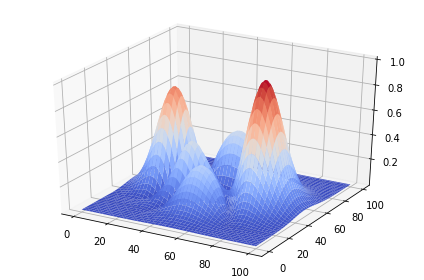

In [4]:
# Plot the 3D plot of pdf
# --------------------------

X = np.arange(0, 100 + 100.0 / (n - 1), 100.0 / (n - 1))
Y = np.arange(0, 100 + 100.0 / (n - 1), 100.0 / (n - 1))
fig0 = plt.figure()
ax = fig0.gca(projection="3d")
X, Y = np.meshgrid(X, Y)
surf = ax.plot_surface(Y, X, pdf, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.1)
# plt.gca().invert_xaxis()
plt.tight_layout()
pml.savefig("sim_anneal_2d_peaks.pdf")
plt.show()

saving image to ../figures/sim_anneal_2d_energy.pdf


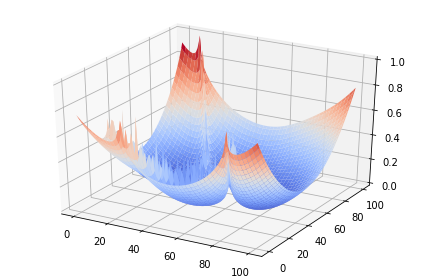

In [5]:
# Plot the 3D plot of Energy function
# --------------------------

X = np.arange(0, 100 + 100.0 / (n - 1), 100.0 / (n - 1))
Y = np.arange(0, 100 + 100.0 / (n - 1), 100.0 / (n - 1))
fig0 = plt.figure()
ax = fig0.gca(projection="3d")
X, Y = np.meshgrid(X, Y)
surf = ax.plot_surface(Y, X, energy / energy.max(), rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.1)
# plt.gca().invert_xaxis()
plt.tight_layout()
pml.savefig("sim_anneal_2d_energy.pdf")
plt.show()

# Heat bath

The "heat bath" refers to a modified version of the distribution in which we vary the temperature. 

saving image to ../figures/sim_anneal_2d_cooled0.pdf
saving image to ../figures/sim_anneal_2d_cooled1.pdf
saving image to ../figures/sim_anneal_2d_cooled2.pdf
saving image to ../figures/sim_anneal_2d_cooled3.pdf


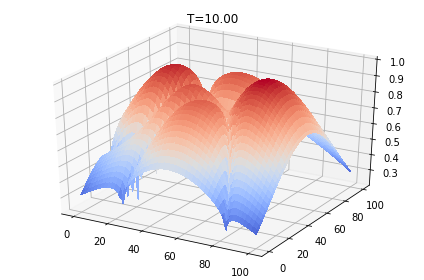

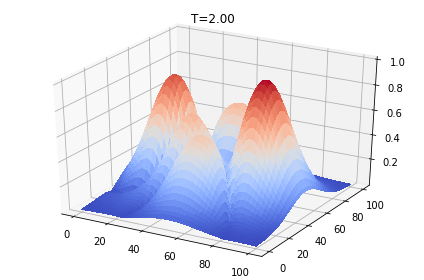

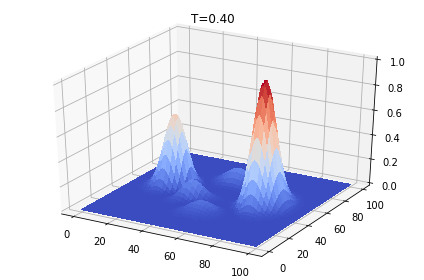

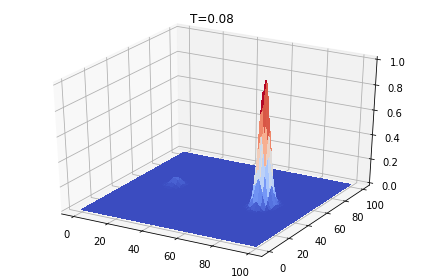

In [6]:
Tplots = 10  # initial temperature for the plots
stepT = 4  # how many steps should the Temperature be *0.2  for

for i in range(0, stepT):
    sigma = np.exp(-(energy) / Tplots)
    sigma = sigma / sigma.max()
    ttl = "T={:0.2f}".format(Tplots)
    Tplots = Tplots * 0.2
    X = np.arange(0, 100 + 100.0 / (n - 1), 100.0 / (n - 1))
    Y = np.arange(0, 100 + 100.0 / (n - 1), 100.0 / (n - 1))
    fig = plt.figure()
    ax = fig.gca(projection="3d")
    X, Y = np.meshgrid(X, Y)
    ax.set_title(ttl)
    ax.plot_surface(Y, X, sigma, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0, antialiased=False)
    # plt.gca().invert_xaxis()
    plt.tight_layout()
    pml.savefig(f"sim_anneal_2d_cooled{i}.pdf")

plt.show()

# SA algorithm

In [54]:
def sim_anneal(proposal="gaussian", sigma=10):
    np.random.seed(42)
    xcur = np.array([np.floor(np.random.uniform(0, 100)), np.floor(np.random.uniform(0, 100))])
    xcur = xcur.astype(int)
    ns = 300  # number of samples to keep
    T = 1  # start temperature
    alpha = 0.99999  # cooling schedule
    alpha = 0.99  # cooling schedule

    # list of visited points, temperatures, probabilities
    x_hist = xcur  # will be (N,2) array
    prob_hist = []
    temp_hist = []

    nreject = 0
    iis = 0  # number of accepted points
    npp = 0  # num proposed points
    while npp < ns:
        npp = npp + 1
        if proposal == "uniform":
            xnew = np.array([np.floor(np.random.uniform(0, 100)), np.floor(np.random.uniform(0, 100))])
        elif proposal == "gaussian":
            xnew = xcur + np.random.normal(size=2) * sigma
            xnew = np.maximum(xnew, 0)
            xnew = np.minimum(xnew, 99)
        else:
            raise ValueError("Unknown proposal")
        xnew = xnew.astype(int)

        # compare energies
        Ecur = energy[xcur[0], xcur[1]]
        Enew = energy[xnew[0], xnew[1]]
        deltaE = Enew - Ecur
        # print([npp, xcur, xnew, Ecur, Enew, deltaE])

        temp_hist.append(T)
        T = alpha * T
        P = np.exp(-1.0 * deltaE / T)
        P = min(1, P)
        test = np.random.uniform(0, 1)
        if test <= P:
            xcur = xnew
            iis = iis + 1
        else:
            nreject += 1

        x_hist = np.vstack((x_hist, xcur))
        prob_hist.append(pdf[xcur[0], xcur[1]])

    npp = npp + 1
    print(f"nproposed {npp}, naccepted {iis}, nreject {nreject}")
    return x_hist, prob_hist, temp_hist

# Run experiments

In [55]:
proposals = {"gaussian", "uniform"}
x_hist = {}
prob_hist = {}
temp_hist = {}
for proposal in proposals:
    print(proposal)
    x_hist[proposal], prob_hist[proposal], temp_hist[proposal] = sim_anneal(proposal=proposal)

uniform
nproposed 301, naccepted 33, nreject 267
gaussian
nproposed 301, naccepted 104, nreject 196


saving image to ../figures/sim_anneal_2d_temp_vs_time_uniform.pdf


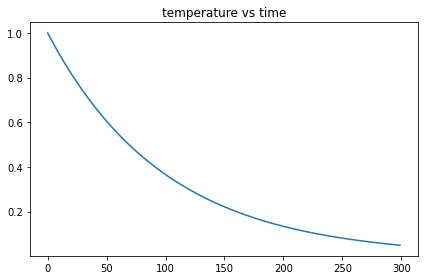

saving image to ../figures/sim_anneal_2d_temp_vs_time_gaussian.pdf


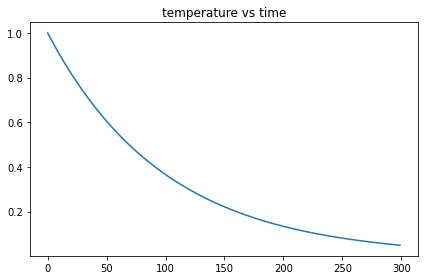

In [56]:
for proposal in proposals:
    plt.figure()
    plt.plot(temp_hist[proposal])
    plt.title("temperature vs time")
    plt.tight_layout()
    pml.savefig(f"sim_anneal_2d_temp_vs_time_{proposal}.pdf")
    plt.show()

saving image to ../figures/sim_anneal_2d_prob_vs_time_uniform.pdf


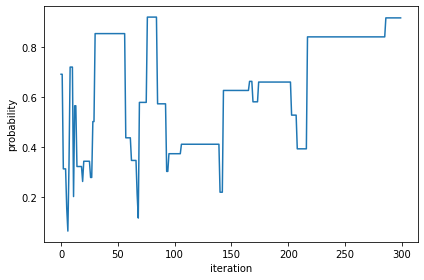

saving image to ../figures/sim_anneal_2d_prob_vs_time_gaussian.pdf


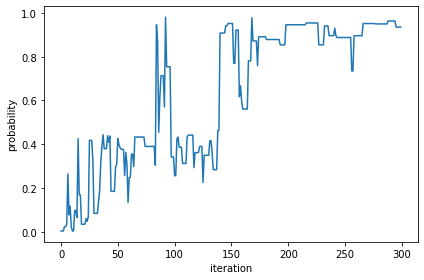

In [57]:
for proposal in proposals:
    plt.figure()
    plt.plot(prob_hist[proposal])
    plt.xlabel("iteration")
    plt.ylabel("probability")
    plt.tight_layout()
    pml.savefig(f"sim_anneal_2d_prob_vs_time_{proposal}.pdf")
    plt.show()

saving image to ../figures/sim_anneal_2d_samples_uniform.pdf


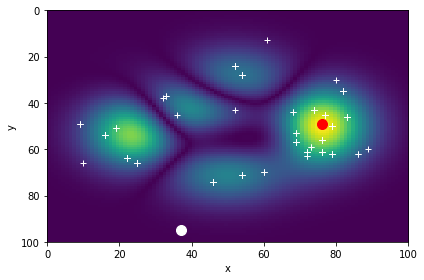

saving image to ../figures/sim_anneal_2d_samples_gaussian.pdf


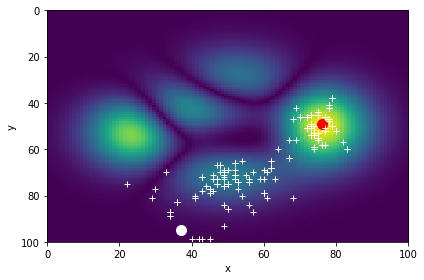

In [58]:
# Plot points visited
for proposal in proposals:
    probs = prob_hist[proposal]
    xa = x_hist[proposal]

    f1, ax = plt.subplots()
    ax.imshow(pdf.transpose(), aspect="auto", extent=[0, 100, 100, 0], interpolation="none")

    # Maximum value achieved ploted with white cirlce
    # maxi = np.argmax(probs) # index of best model
    # ax.plot(xa[maxi,0],xa[maxi,1],'wo', markersize=10)

    # Starting point with white cirlce
    ax.plot(xa[0, 0], xa[0, 1], "wo", markersize=10)

    # Global maximm with red cirlce
    ind = np.unravel_index(np.argmax(pdf, axis=None), pdf.shape)
    ax.plot(ind[0], ind[1], "ro", markersize=10)

    ax.plot(xa[:, 0], xa[:, 1], "w+")  # Plot the steps with white +

    ax.set_ylabel("y")
    ax.set_xlabel("x")
    plt.tight_layout()
    pml.savefig(f"sim_anneal_2d_samples_{proposal}.pdf")
    plt.show()